In [1]:
from importlib import reload
from src.Game import Game
from src.Players.Minesweeper_bot import Minesweeper_bot
from src.UI.GUI_Bot_Inputs import GUI_Bot_Inputs
from src.UI.No_UI import No_UI
from src.Grid import Grid
from models.Game_Tensor_Interface import Game_Tensor_Interface
from src.UI.GUI_User_Inputs import GUI_User_Inputs
from src.UI.Command_Line_UI import Command_Line_UI
import src.Players.Minesweeper_bot as mb

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
from torch import Tensor

import models.Game_Tensor_Interface as t_int
import torch
from scipy.signal import convolve2d
from torchmetrics import Accuracy


In [2]:
from Lightning import config
from Lightning.Dataset import Data_Module


dm = Data_Module(config.TENSOR_DATA_FILE, config.BATCH_SIZE, config.VAL_SIZE)
dm.prepare_data()
dm.setup('fit')
batch = next(iter(dm.train_dataloader()))

In [3]:
grid_tensor, mines = batch

In [6]:
img = Game_Tensor_Interface.view_grid_tensor(grid_tensor[0], mines[0], view_grid_kwargs={'close_plot':True})

In [2]:
grid_size = 8
mine_percent = 0.15
initial_action = (5, 5)
device = torch.device('cuda')


In [3]:

# From existing data training
dataset = torch.load('dataset/lose_bot/12x12_23253.pt') # Shape : [2990, 10, 8, 8]

In [4]:
all_symetries = [
    lambda t: torch.rot90(t, k=0, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=1, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=2, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=3, dims=(-2, -1)),
    lambda t: torch.flip(t, dims=(-1,)),
    lambda t: torch.flip(t, dims=(-2,)),
    lambda t: torch.flip(torch.rot90(t, k=-1, dims=(-2, -1)), dims=(-1,)),
    lambda t: torch.flip(torch.rot90(t, k=1, dims=(-2, -1)), dims=(-1,))
]

all_symetries_inverse = [
    lambda t: torch.rot90(t, k=0, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=-1, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=-2, dims=(-2, -1)),
    lambda t: torch.rot90(t, k=-3, dims=(-2, -1)),
    lambda t: torch.flip(t, dims=(-1,)),
    lambda t: torch.flip(t, dims=(-2,)),
    lambda t: torch.flip(torch.rot90(t, k=-1, dims=(-2, -1)), dims=(-1,)),
    lambda t: torch.flip(torch.rot90(t, k=1, dims=(-2, -1)), dims=(-1,))
]

In [5]:
from sklearn.model_selection import train_test_split
import torch.utils
from torch.utils.data import TensorDataset, DataLoader

random_seed = 86431
train_data, test_data, train_mines, test_mines = train_test_split(*dataset, test_size=0.1, shuffle=False, random_state=random_seed) # Do not shuffle to not mix the same grids in training and test
train_dataset = TensorDataset(train_data.type(torch.float32).to(device), train_mines.to(device))
test_dataset = TensorDataset(test_data.type(torch.float32).to(device), test_mines.to(device))


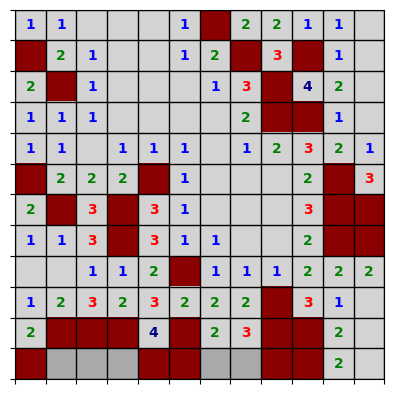

In [6]:
Game_Tensor_Interface.view_grid_tensor(train_data[0], np.array(train_mines[0]))

In [7]:
from torch.nn import Module


class Symetry_Inveriant_Conv2D(Module):
    def __init__(self, conv_layer: Module, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_layer = conv_layer

    def forward(self, x: Tensor) -> Tensor:
        # [n, C, H, W]
        input_shape = x.shape

        # Compute all symetries
        # [n, 8, C, H, W]
        x = torch.stack([f(x) for f in all_symetries], -4)

        # Linearize along the batch dimension
        # [n*8, C, H, W]
        x = torch.reshape(x, (-1, *x.shape[-3:]))

        # Apply the conv_layer
        # [n*8, c, h, w]
        x = self.conv_layer(x)

        # Nest back to original first dimensions shape
        # [n, 8, c, h, w]
        nested_shape = (*input_shape[:-3], 8, *x.shape[-3:])
        x = torch.reshape(x, nested_shape)

        # Inverse the symetries
        # [n, 8, c, h, w]
        x = torch.stack([f(t[:, 0]) for t, f in zip(torch.split(x, 1, dim=-4), all_symetries_inverse)], -4)

        # Agregate
        # [n, c, h, w]
        x = torch.amax(x, dim=-4)

        return x
    
# # Test
# symetry_invariant_model = Symetry_Inveriant_Conv2D(
#     nn.Conv2d(3, 5, 3),
# )
# t = torch.rand((10, 3, 15, 15))
# result = symetry_invariant_model(t)
# t_symetries = [f(t) for f in all_symetries]
# result_symetries = [symetry_invariant_model(x) for x in t_symetries]
# result_all = [f(x) for x, f in zip(result_symetries, all_symetries_inverse)]
# print([float(torch.sum((result-r)**2)) for r in result_all])
# print(result.shape)

In [8]:
# model = nn.Sequential(
#     nn.Conv2d(10, 16, 9, padding='same', padding_mode='zeros'),
#     nn.ReLU(),
#     nn.Conv2d(16, 16, 9, padding='same', padding_mode='zeros'),
#     nn.ReLU(),
#     nn.Conv2d(16, 8, 9, padding='same', padding_mode='zeros'),
#     nn.ReLU(),
#     nn.Conv2d(8, 2, 1),
#     nn.LogSoftmax(-3),
# )

model = nn.Sequential(
    Symetry_Inveriant_Conv2D(
        nn.Sequential(
            nn.Conv2d(10, 16, 9, padding='same', padding_mode='zeros'),
            nn.ELU(),
        )
    ),
    Symetry_Inveriant_Conv2D(
        nn.Sequential(
            nn.Conv2d(16, 16, 9, padding='same', padding_mode='zeros'),
            nn.ELU(),
        )
    ),
    Symetry_Inveriant_Conv2D(
        nn.Sequential(
            nn.Conv2d(16, 2, 1, padding='same', padding_mode='zeros'),
            nn.ELU(),
        )
    ),
    nn.LogSoftmax(-3),
)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
# Ouput : [class_log_proba, h, w]
# class_log_proba : [empty, mine]

# Lists to store loss values
train_losses = []
val_losses = []
bad_streak = 0

  0%|          | 0/20 [00:00<?, ?it/s]

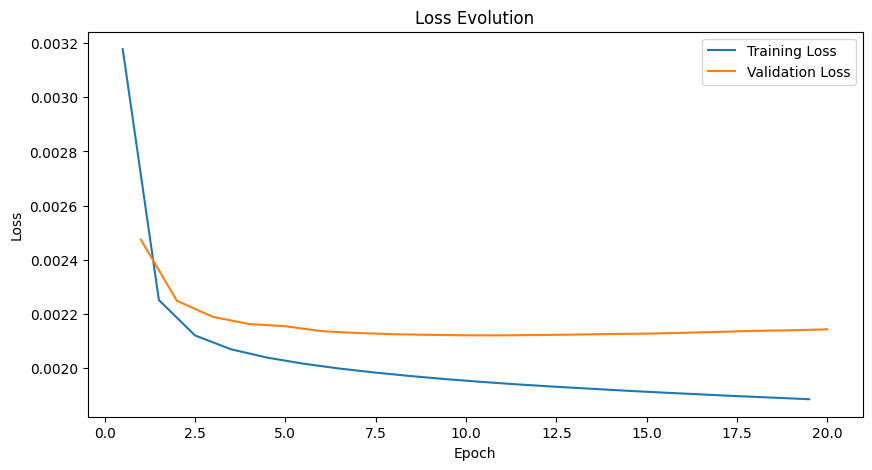

In [9]:
n_epoch = 20
batch_size = 128
temp_save_file = 'tmp/best_model_parameters.pt'
early_stoping = 5

alpha = 0.95 # Part of loss on the Unknown boundaries
def compute_loss(model, grid_tensor, mines):
    model_output = model(grid_tensor)

    boundary = Game_Tensor_Interface.unknown_boundaries(grid_tensor)

    part_loss = model_output[:, 0]*(1-mines*1) + model_output[:, 1]*(mines*1)

    boundary_loss = - torch.mean(part_loss[boundary])
    flat_loss = - torch.mean(part_loss[~boundary])

    # Kullback leibler divergence
    loss = alpha * boundary_loss + (1-alpha)*flat_loss
    return loss

# Training loop
for e in tqdm(range(n_epoch)):
    model.train()
    running_train_loss = 0.0
    for grid_tensor, mines in DataLoader(train_dataset, batch_size=batch_size, shuffle=False):
        optimizer.zero_grad()
        # Optimize the model
        loss = compute_loss(model, grid_tensor, mines)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    for grid_tensor, mines in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
        with torch.no_grad():
            loss = compute_loss(model, grid_tensor, mines)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_dataset)
    if avg_val_loss < running_val_loss:
        torch.save(model.state_dict(), temp_save_file)
        bad_streak = 0
    else:
        bad_streak += 1
    val_losses.append(avg_val_loss)

    if bad_streak >= early_stoping:
        print('Early stoping')
        break

model.load_state_dict(torch.load(temp_save_file))
# Plotting the loss evolution
epoch_plot = np.arange(len(train_losses))
plt.figure(figsize=(10, 5))
plt.plot(epoch_plot+0.5, train_losses, label='Training Loss')
plt.plot(epoch_plot+1, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

In [13]:
# model.load_state_dict(torch.load('model_parameters/model_1.pt'))

In [14]:
grid_tensor, mines = test_dataset[-22:]
model.eval()
with torch.no_grad():
    model_output = model(grid_tensor).to('cpu')

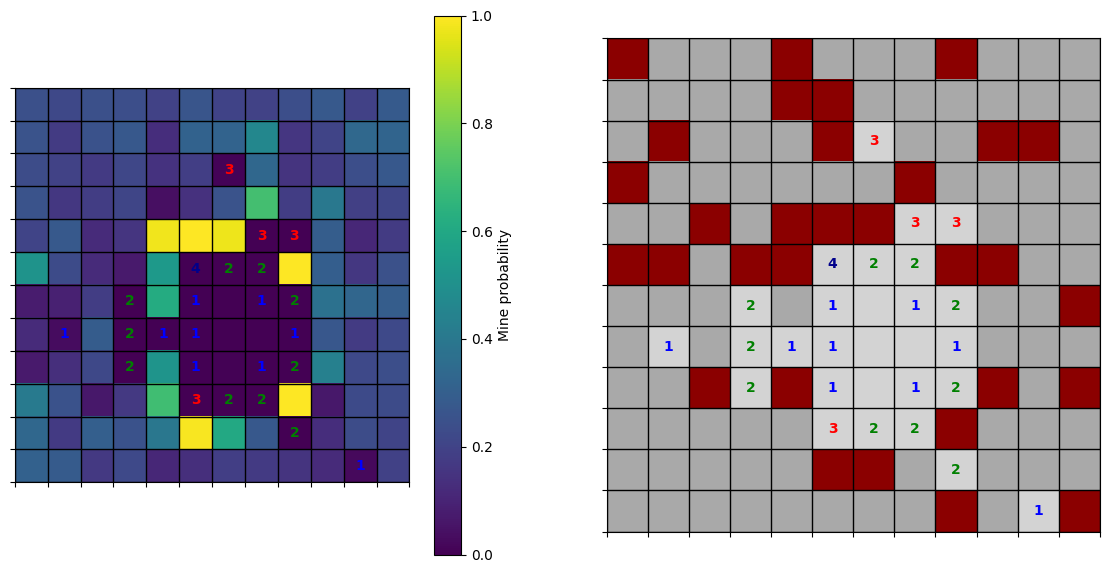

In [15]:
from matplotlib.axes import Axes
import models.Game_Tensor_Interface as gi
reload(gi)
base_size = 7
fig, axs = plt.subplots(1, 2, figsize=(2*base_size, base_size))
axs: list[Axes]
ax_proba = axs[0]
gi.Game_Tensor_Interface.view_grid_tensor(grid_tensor[0].to('cpu'), mines[0].to('cpu'), view_grid_kwargs={'fig':fig, 'ax':ax_proba})
proba_plot = ax_proba.imshow(torch.exp(model_output[0, 1]), vmin=0, vmax=1)
fig.colorbar(proba_plot, ax=ax_proba, label='Mine probability')

ax_grid = axs[1]
gi.Game_Tensor_Interface.view_grid_tensor(grid_tensor[0].to('cpu'), mines[0].to('cpu'), view_grid_kwargs={'fig':fig, 'ax':ax_grid})
pass

In [16]:
from numpy import ndarray
from torch.nn import Module
from src.Players.Player_Interface import Player_Interface

def valid_argmax2D(tensor, grid_view):
    valid_flat = ~torch.flatten(torch.tensor(grid_view))
    output_flat = torch.flatten(tensor)

    valid_indices = torch.where(valid_flat)[0]
    valid_max_index = torch.argmax(output_flat[valid_indices])
    valid_indices[valid_max_index]

    if grid_view.shape[0] != grid_view.shape[1]:
        raise NotImplementedError()
    
    max_row = valid_indices[valid_max_index] // grid_view.shape[0]
    max_col = valid_indices[valid_max_index] % grid_view.shape[0]
    return max_row, max_col

class Model_Based_Player(Player_Interface):
    def __init__(self, model: Module, out_of_boundary_treshold:float=0.1) -> None:
        super().__init__()
        self.tensor_interface = Game_Tensor_Interface()
        self.model = model
        self.out_of_boundary_treshold = out_of_boundary_treshold

    def action(self, grid: ndarray, grid_view: ndarray) -> tuple[int, int]:
        tensor_representation = self.tensor_interface.to_tensor(grid, grid_view).type(torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(tensor_representation.reshape((1, *tensor_representation.shape)))[0]

        no_mines_proba = torch.exp(model_output[0])

        # Remove the possibility to pick a non boundary box by giving it negative probability
        boundary = Game_Tensor_Interface.unknown_boundaries(tensor_representation.reshape(1, *tensor_representation.shape))[0]
        no_mines_proba -= (~boundary)*1

        # If the remaining boxes are not in the boundary (can append if an area is surronded by mines)
        if torch.max(no_mines_proba) < self.out_of_boundary_treshold:
            # Allow to choose a non boundary box
            no_mines_proba += (~boundary)*1
        
        return valid_argmax2D(no_mines_proba.to('cpu'), grid_view)

In [34]:
from numpy import ndarray


class Print_Usage(Model_Based_Player):
    def action(self, grid: ndarray, grid_view: ndarray) -> tuple[int, int]:
        print('Use the model')
        return super().action(grid, grid_view)

grid = Grid(20, 20, 0.25)
game = Game(grid)
game.action(*initial_action)
GUI_Bot_Inputs(delay=10).start(game, mb.Minesweeper_bot(delegated_if_no_solution=Print_Usage(model)))
# Command_Line_UI().start(game, Model_Based_Player(model))

Use the model
Use the model
Use the model
Use the model
Use the model
Use the model
Use the model
Use the model


True

In [30]:
# Undo the incorect move
game.player_grid_view = np.logical_and(
    game.player_grid_view,
    ~np.logical_and(grid.mines, game.player_grid_view),
)

In [76]:
tensor_representation = Game_Tensor_Interface().to_tensor(*game.visible_grid())
mines = grid.mines
model.eval()
with torch.no_grad():
    model_output = model(
        tensor_representation.reshape(1, *tensor_representation.shape).to('cuda')
    )[0].to('cpu')

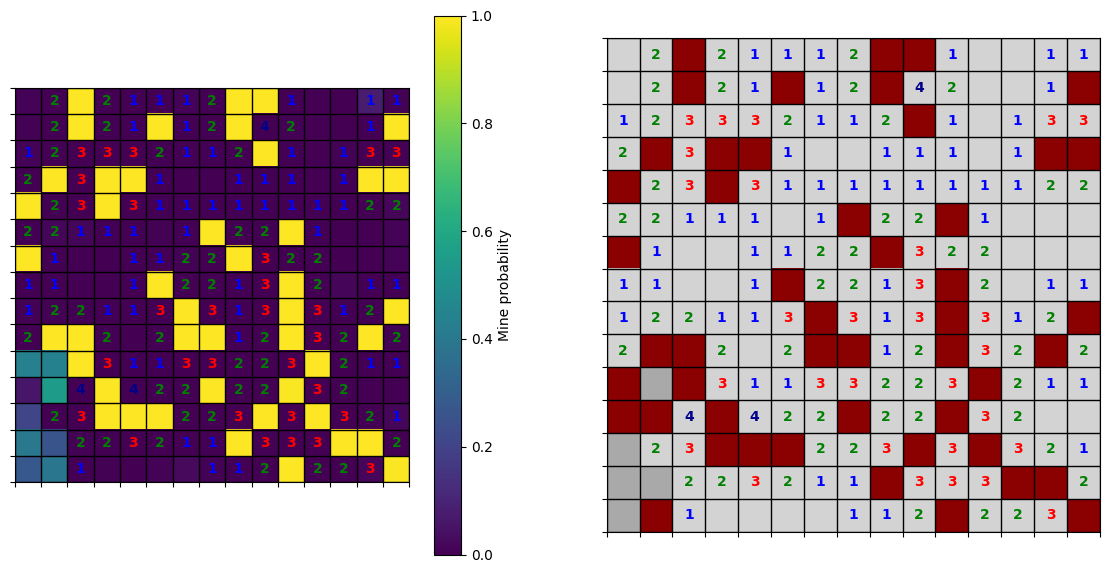

In [77]:
from matplotlib.axes import Axes
import models.Game_Tensor_Interface as gi
reload(gi)
base_size = 7
fig, axs = plt.subplots(1, 2, figsize=(2*base_size, base_size))
axs: list[Axes]
ax_proba = axs[0]
gi.Game_Tensor_Interface.view_grid_tensor(tensor_representation, mines, view_grid_kwargs={'fig':fig, 'ax':ax_proba})
proba_plot = ax_proba.imshow(torch.exp(model_output[1]), vmin=0, vmax=1)
fig.colorbar(proba_plot, ax=ax_proba, label='Mine probability')

ax_grid = axs[1]
gi.Game_Tensor_Interface.view_grid_tensor(tensor_representation, mines, view_grid_kwargs={'fig':fig, 'ax':ax_grid})
pass

In [122]:
import numpy as np
from scipy import stats

def confidence_interval(data, alpha=0.05):
    """
    Compute the alpha confidence interval of the mean for a given dataset.

    Parameters:
    - data (numpy array): Array of sampled values.
    - alpha (float): Significance level, default is 0.05 for a 95% confidence interval.

    Returns:
    - (float, float): The lower and upper bounds of the confidence interval.
    """
    n = len(data)  # Sample size
    mean = np.mean(data)  # Sample mean
    std_err = np.std(data, ddof=1) / np.sqrt(n)  # Standard error of the mean

    # Compute the t critical value
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)

    # Compute the margin of error
    margin_of_error = t_crit * std_err

    # Compute the confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error

    return ci_lower, ci_upper

def winrate(n_game, mine_percent, grid_size, bot, conf_interval: None|float):
    results = []
    for i in range(n_game):
        grid = Grid(grid_size, grid_size, mine_percent)
        game = Game(grid)
        result = No_UI().start(game, bot)
        results.append(result)

    if conf_interval is None:
        return np.mean(results)
    return confidence_interval(results, conf_interval)


In [127]:


winrate(1000, 0.15, grid_size, mb.Minesweeper_bot(delegated_if_no_solution=Model_Based_Player(model)), 0.05)

(0.9031565619736741, 0.936843438026326)

In [128]:
winrate(1000, 0.15, grid_size, Minesweeper_bot(), 0.05)

(0.8889682883602471, 0.925031711639753)

## Meilleure mesure

Pour chaque grille de test, calculer la probabilité de séléctionner une case sans bombe de chaque modèle:
    - 0 ou 1 pour notre modèle appris
    - (n_case_libres)/(n_cases_candidates) pour Minesweeper_Bot

Faire la moyenne sur l'ensemble des grilles

In [14]:
# Model computations
model_success_list = []
for grid_tensor, mines in tqdm(DataLoader(test_dataset, batch_size=batch_size, shuffle=False)):
    model_output = model(grid_tensor)

    no_mines_proba = torch.exp(model_output[:, 0])

    # Remove the possibility to pick a non boundary box by giving it negative probability
    boundary = Game_Tensor_Interface.unknown_boundaries(grid_tensor)
    no_mines_proba -= (~boundary)*1

    grid_view = grid_tensor[:, -1] == 0

    model_success_list.extend([
        not bool(m[*valid_argmax2D(nm, v)])
        for m, nm, v in zip(mines, no_mines_proba, grid_view)
    ])

  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\toine\AppData\Local\Temp\ipykernel_15872\1572078364.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_flat = ~torch.flatten(torch.tensor(grid_view))


In [24]:
from numpy import ndarray



class None_Action_Bot(Player_Interface):
    def action(self, grid: ndarray, grid_view: ndarray) -> tuple[int, int]:
        return None

bot_success_list = []
for grid_tensor, mines in tqdm(test_dataset):
    grid_values, grid_view = Game_Tensor_Interface.visible_grid(grid_tensor.to('cpu'))

    # Computebot.known_mines
    bot = Minesweeper_bot(delegated_if_no_solution=None_Action_Bot())
    next_action = bot.action(grid_values, grid_view)

    if next_action is not None:
        raise 'Minesweeper_bot should not be able to solve this grid'

    possible_actions = np.argwhere(np.logical_and(
        ~grid_view,
        ~bot.known_mines,
    ))

    mines_cpu = mines.to('cpu')
    bot_success_list.append(
        np.mean([
            ~mines_cpu[i, j] for i, j in possible_actions
        ])
    )

  0%|          | 0/2326 [00:00<?, ?it/s]

In [30]:
np.mean(model_success_list), np.mean(bot_success_list)

(0.7527944969905417, 0.6499802693033881)